# 0. Import Packages

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import joblib
pd.set_option('display.max_columns', None)

# 1. Read Data and Inspect

In [12]:
#importing original data and previously worked dataframe
train = pd.read_csv("../project_data/original_data/train.csv")
df_train = pd.read_csv("../project_data/handout_data/training_handout.csv")

In [13]:
df_train.columns

Index(['Unnamed: 0', 'brand', 'model', 'price', 'transmission', 'mileage',
       'fuelType', 'tax', 'mpg', 'engineSize', 'car_age', 'mileage_per_year'],
      dtype='object')

In [14]:
print(train.shape)
df_train.shape

(75973, 14)


(75973, 12)

In [8]:
#remove unnamed 0 column
df_train = df_train.drop(columns=['Unnamed: 0'])
df_train

,brand,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,car_age,mileage_per_year
0,vw,golf,22290,semi-auto,28421.0,petrol,NaN,11.4,2.0,4.0,7105.250000
1,toyota,yaris,13790,manual,4589.0,petrol,145.0,47.9,1.5,1.0,4589.000000
2,audi,q2,24990,semi-auto,3624.0,petrol,145.0,40.9,1.5,1.0,3624.000000
3,ford,fiesta,12500,manual,9102.0,petrol,145.0,65.7,1.0,2.0,4551.000000
4,bmw,2 series,22995,manual,1000.0,petrol,145.0,42.8,1.5,1.0,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...
75968,mercedes,c class,13498,manual,14480.0,petrol,125.0,53.3,2.0,5.0,2896.000000
75969,audi,q3,12495,semi-auto,52134.0,diesel,200.0,47.9,2.0,7.0,7447.714286
75970,toyota,aygo,8399,automatic,11304.0,petrol,145.0,67.0,1.0,3.0,3768.000000
75971,audi,q3,12990,manual,69072.0,diesel,125.0,60.1,2.0,5.0,13814.400000


### Missing Data

In [6]:
miss = df_train.isna().sum()
mv = pd.DataFrame({"missing": miss[miss>0], "missing_%": (miss[miss>0]/len(df_train)*100).round(2)}).sort_values("missing_%", ascending=False)
if not mv.empty:
    print("\nMissing-values summary (non-zero):")
    print(mv.head(20))


Missing-values summary (non-zero):
                  missing  missing_%
tax                  8282      10.90
mpg                  7962      10.48
mileage_per_year     3645       4.80
transmission         2263       2.98
car_age              1849       2.43
mileage              1832       2.41
engineSize           1780       2.34
model                1721       2.27
fuelType             1678       2.21
brand                  43       0.06


- There is not that much missing data in almost every feature besides tax and mpg.
- In our case, if we have a car with some missing values and another of the same brand and model with those values filled we can pretty much use that car to fill the gaps of the 1st one, even tough same brand and model can have diferent specifications, we believe it's a logical and valid approach.

In [7]:
# These lines seem to be bad but when we remove them the model actually performs worst
df_train[df_train["brand"].isnull()]

,brand,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,car_age,mileage_per_year
442,NaN,NaN,8600,manual,28820.0,diesel,0.0,74.4,1.5,3.0,9606.666667
2031,NaN,NaN,21300,automatic,11258.0,NaN,145.0,64.2,2.0,2.0,5629.000000
2223,NaN,NaN,12990,automatic,43000.0,diesel,145.0,54.3,2.1,7.0,6142.857143
4250,NaN,NaN,25495,semi-auto,4255.0,petrol,145.0,44.8,1.3,1.0,4255.000000
5513,NaN,NaN,8997,manual,11200.0,petrol,30.0,58.0,1.3,3.0,3733.333333
5967,NaN,NaN,19750,semi-auto,9500.0,petrol,145.0,55.4,1.5,2.0,4750.000000
6233,NaN,NaN,29250,automatic,10055.0,diesel,145.0,47.9,2.0,1.0,10055.000000
7793,NaN,NaN,15499,semi-auto,64315.0,diesel,145.0,54.3,2.0,3.0,21438.333333
12893,NaN,NaN,14999,manual,29053.0,diesel,20.0,64.2,2.1,5.0,5810.600000
13087,NaN,NaN,16500,manual,3000.0,diesel,145.0,57.7,1.6,1.0,3000.000000


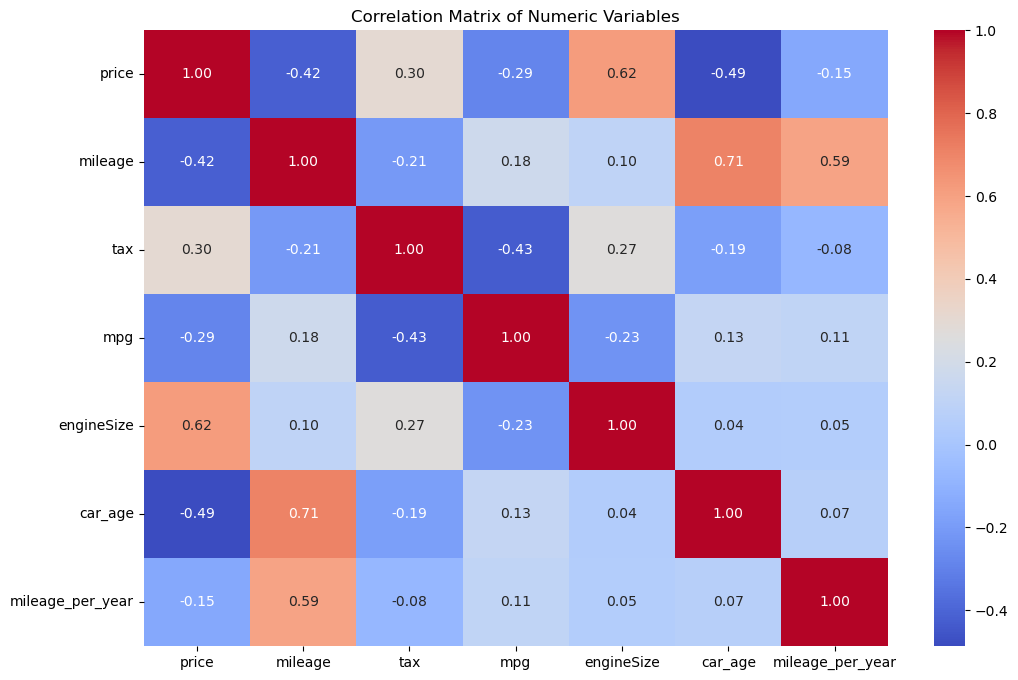

In [8]:
numeric_cols = df_train.select_dtypes(include=['int64', 'Int64', 'float64']).columns

# Compute correlation matrix
corr_matrix = df_train[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

- On one hand it seems like a good opportunity to use a KNN imputer because the missing data is way below the common treshold of 30% and the missing data seems to be MAR
- On the other, the correlations between numeric variables is not the best since in most cases the r is lower than 0.3 plus the imputation of mode grouped by brand and model seems to also make very sense, as the knn imputer would be prone to do something that is out of reality like imputing models to brands that don´t exist and values that also don´t exist
- For now we will imput the mode, but it can be worth to try to compare the performance these 2 ways of imputation or even using both

# 2. Modify the Data

## Split the data

In [9]:
feature_cols = [c for c in df_train.columns if c != "price"]

X = df_train[feature_cols].copy()
y = df_train["price"].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=44, shuffle=True
)

In [10]:
y_train_transformed = np.log1p(y_train)  
y_val_transformed = np.log1p(y_val)

Log the target variable since it´s a variable whit a great tail (a lot of outliers)

## Pipeline construction

### Column Transformers

In [11]:
class RareLabelGrouper(BaseEstimator, TransformerMixin):
    """
    This class will be useful to identify and group rare instances in a column. The minimal proportion needed to not be grouped is min_prop.
    """
    def __init__(self, min_prop=0.005, column=None): #Buildng the class
        self.min_prop = min_prop
        self.column = column
        self.keep_values_ = None  #This will be used to store the values to group
    def fit(self, X, y=None):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])  #We need to use a pandas series, and this ensures it is one
        vc = s.value_counts(dropna=False)  #Counts the amount of times each value appears
        total = len(s)  
        keep = vc[vc / total >= self.min_prop].index #Chooses the categories for which the minimum proportion is met
        self.keep_values_ = set(keep.tolist()) # Attributes them to an attribute of the class in the form of a list
        return self
    def transform(self, X):
        """
        np.where() works like an if-else statement. If s is in stored values to keep, then keep s, else attribute "Other".
        To attribute the name of the column, if it was passed and stored in the attribute .column, then use that name, else use the generic 'col' name.
        """
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])  #Same pandas series problem
        return pd.DataFrame(np.where(s.isin(self.keep_values_), s, "Other"),  
                            columns=[self.column if self.column else "col"])


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Selects a single column from the incoming DataFrame X, based on the column name provided at initialization.
    This column is returned as a DataFrame
    """
    def __init__(self, column): self.column = column
    def fit(self, X, y=None): return self
    def transform(self, X): return pd.DataFrame(X[self.column])

class CustomWinsorizer(BaseEstimator, TransformerMixin):
    """
    Takes care of outliers by winsorizing selected numeric variables.
    During fit(), it learns the lower and upper quantile limits for each variable.
    During transform(), any value below the lower limit is replaced with that limit, and any value above the upper limit is capped at the upper limit.
    This reduces the influence of extreme values while keeping all observations in the dataset.
    """
    def __init__(self, variables, lower_bound=0.01, upper_bound=0.99):
        self.variables = variables  #is a list of the columns we want to apply the transformer to (Confirmable further)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.limits_ = {} #Will store the value of the limits calculated in fit() to apply in transform()

    def fit(self, X, y=None):
        for var in self.variables:  #Iterates over all columns specified in the list
            if var in X.columns:  #Makes sure it is one of the DataFrame's columns
                lower_limit = X[var].quantile(self.lower_bound)  #Calculates the lower-limit
                upper_limit = X[var].quantile(self.upper_bound)  #Calculates the upper-limit
                self.limits_[var] = (lower_limit, upper_limit)  #Stores the limits calculated for use in transform(). It's stored associated to a key with the name of the column
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var, (lower_limit, upper_limit) in self.limits_.items():  #Iterates over all columns chosen to transform
            if var in X.columns:  #Defensive programming to make sure the column is there
                X_transformed[var] = np.clip(X_transformed[var], lower_limit, upper_limit) #Replaces values in the series that are higher than lower_limit with the lower limit and the same for the upper limit
        return X_transformed


# BaseEstimator → dá compatibilidade com pipelines, grid-search e clonagem
# TransformerMixin → fornece fit_transform() automaticamente
class Mode_Imput_By_Brand (BaseEstimator, TransformerMixin):

    """
    O objetivo com este transformer é preencher os valores nulos de cada coluna através da moda, mas primeiro, agrupar por brand.
    Como fallback, caso nao haja nenhuma linha preenchida daquela brand em especifico, depois de utilizar este transformer
    iremos utilzar o SimpleImputer.
    
    """
    
    def __init__(self, imput_cols = None , group_col = "brand"):       
        self.imput_cols = imput_cols  #Store the imputing values for each group
        self.group_col = group_col #Stores the variable name in which we want to group to input the value we need (for example, group by the brand to input the most likely model of a given car)

    # é obrigatorio colocar X e y em todos os metodos de fit do sklearn
    def fit(self , X, y = None):
        X = X.copy()  # em qualquer metodo do sklearn criamos uma copia do df original, pois no pipeline é usado o mesmo df nao modificado para os vários passos
        
        if self.imput_cols is None: # sklearn nao gosta de args obrigatórios entao fazemos isto para contornar
            self.imput_cols = [col for col in X.columns if col != self.group_col] #Iterates over all columns that are not group_col and stores their names in a list 
        
        self.mode_maps_ = {}

        for col in self.imput_cols:  #Iterate over all columns except the group_col
            mode_map = X.groupby(self.group_col)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)  #Calculates the mode for each group and if there isn't assume np.nan
            self.mode_maps_[col] = mode_map

        return self # o .fit do sklearn retorna sempre o self
    
    def transform(self, X):
        X = X.copy()

        for col in self.imput_cols:  #Iterate over all columns except the group_col
            X[col] = X[col].fillna(X[self.group_col].map(self.mode_maps_[col]))  #Fills all nans in one column (col) with the mode found in the mode_maps_ dict, which contains the mode for the different groups that were grouped through the group_col

        return X

In [12]:
class Imput_By_Brand_and_Model (BaseEstimator, TransformerMixin):

    """

    The goal with this transformer is to fullfill the Nans by the mode,  but 1st grouping by brand and model. Has a fallback
    in the pipeline, after using this transformer, it should be used a SimplImputer to guarantee that in the end, there is no missing
    values.

    =============================================================================================================================

    Attributes:

        imput_cols: List of cols you want to imput, if none is passed then it will assume all columns should be imputed besides the 
        ones on the group_cols

        group_cols: List of cols you want to groupby, it's defaulted to be brand and model

        .mode_maps: Dictionary for each imput column, where each key is an imput_col and each value is a dictionary where each key is
                    a combiantion of brand and model and each value is the mode

    ==============================================================================================================================

    Methods:
    
        .fit: Creates a loop that for each column to imput: 0. Creates an empty dict to store each imput col as a key
                                                            1. Groups the data by the group_cols
                                                            2. Calculates the mode, if more than 1 get´s the 1st one 
                                                            if there is no value it returns Nan
                                                            3. Stores the combination of brand and model (group_cols) and mode
                                                            as a key-value pair 
        
        .transform: 1. For each row of the dataset stores the pair of (brand,model) into a Series
                    2. Loops trough the imput_cols and for each one it uses the pairs created before as a key to get the value of 
                    the mode_maps, storing this value in a Series called mapped
                    3. Goes trough each line of the data, if the value is nan it fulfiles it with the corresponding value of the
                    mapped series

        
    """

    def __init__(self, imput_cols = None , group_cols = ["brand", "model"]):       
        self.imput_cols = imput_cols
        self.group_cols = group_cols

    
    def fit(self , X, y = None):
        X = X.copy()  
        
        if self.imput_cols is None: 
            self.imput_cols = [col for col in X.columns if col != self.group_cols]
        
        self.mode_maps = {}

        for col in self.imput_cols:
            mode_map = X.groupby(self.group_cols)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) 
            self.mode_maps[col] = mode_map.to_dict()

        return self 
    
    def transform(self, X):
        X = X.copy()

        keys = list(zip(*[X[g] for g in self.group_cols]))  # [(brand, model), ...]
        key_series = pd.Series(keys, index=X.index)

        for col in self.imput_cols:
            mapped = key_series.map(self.mode_maps[col])
            X[col] = X[col].fillna(mapped)

        return X

#### Testing Transformers

In [13]:
mode_maps = {}
group_cols = ["brand","model"]
imput_cols = ["tax", "mpg"]

In [14]:
imp = Imput_By_Brand_and_Model(imput_cols)
imp.fit(X_train)
mode_maps_ = imp.mode_maps

In [15]:
X_train.groupby(["brand", "model"])["mpg"].apply(lambda x: x.mode())

brand  model             
audi   a1               0    55.4
       a2               0    65.7
       a3               0    60.1
       a4               0    70.6
       a5               0    39.8
                             ... 
vw     tiguan           0    49.6
       tiguan allspace  0    38.7
       touareg          0    42.8
       touran           0    61.4
       up!              0    64.2
Name: mpg, Length: 210, dtype: float64

In [16]:
key_series = pd.Series(list(zip(*[X_val[g] for g in group_cols])))

In [17]:
test = X_train.copy()
test["model"].isnull().sum()

np.int64(1364)

In [18]:
imput = Mode_Imput_By_Brand(imput_cols = ["model"])
imput.fit(test)
imput.mode_maps_

{'model': brand
 audi              a3
 bmw         3 series
 ford           focus
 hyundai       tucson
 mercedes     c class
 opel           corsa
 skoda          fabia
 toyota         yaris
 vw              golf
 Name: model, dtype: object}

Seems to be working has intended since for each column will create a dict with the brand and the mode for that column for that brand

In [19]:
test = imput.transform(test)
test["model"].isnull().sum()
# these 37 rows need a fallback imputer, cause probably are the ones missing brand

np.int64(37)

### Scalling Data

Scaling

- **Why scale:** Linear/regularized models are scale-sensitive. Numeric features can have very different ranges (ex: mileage vs engine size), which biases coefficients.

- **Choice:** **StandardScaler** for numeric columns (after imputation and outlier capping).

- **StandardScaler over MinMaxScaler:** Standardization centers and normalizes variance—well-aligned with Ridge/Lasso penalties and keeps One-Hot Enconding interpretable. All scaling is fit on the training fold only within the pipeline to ensure that there are **no leakage**.

In [13]:
scaler = StandardScaler()

In [14]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()  #Numeric columns
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]  #Categorical columns
without_model = [c for c in X_train.columns if c not in numeric_cols + ['model']]  #Categorical - 'model'
without_model_brand = [c for c in X_train.columns if c not in ["model", "brand"]]  #Categorical - 'model' - 'brand'
skewness = X_train[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)  #Calculates the skew of the distribution for each column and sorts it 
log_candidates = [c for c, s in skewness.items() if np.isfinite(s) and s > 1.0]  #Highly right-skewd
log_candidates = [c for c in log_candidates if (X_train[c].dropna() >= 0).all()] #Highly roght-skewed and all values are positive
outlier_variable = ['tax'] #Yeah, taxes

In [15]:
def log1p_selective(df_num):
    """
    Takes the columns in log_candidates (highly right-skewed and positive) and transforms them using log(1+x)
    """
    df_num = pd.DataFrame(df_num, columns=numeric_cols)
    for c in log_candidates:
        df_num[c] = np.log1p(df_num[c])
    return df_num

log_transformer = FunctionTransformer(log1p_selective, validate=False)  #Turns the function into a sklearn transformer

#Creates a Pipeline with all the transformers we created.
#It applies the winsor, then the imputer(median), log_transformer, and a StandardScaler (x-mean)/std
numeric_pipeline = Pipeline([('winsor', CustomWinsorizer(variables=outlier_variable, lower_bound=0.01, upper_bound=0.99)), ("imputer", SimpleImputer(strategy="median")),("log1p_skewed", log_transformer), ("scaler", scaler)])

#This one is the same as the other, but without the winsor and with the RobustScaler() (x-median)/IQR
numeric_pipeline_2 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p_skewed", log_transformer),  
    ("scaler", RobustScaler())
])

In [16]:
cats = []
cats.append(("cat",
                 Pipeline([("fallback_impute", SimpleImputer(strategy="most_frequent")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                without_model))
cats.append(("model_collap",
                 Pipeline([("select", ColumnSelector("model")),
                           ("fallback_impute", SimpleImputer(strategy="most_frequent")),
                           ("rare", RareLabelGrouper(min_prop=0.005, column="model")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                  ["model"] ))

In [17]:
preprocessor = ColumnTransformer([("num", numeric_pipeline_2, numeric_cols), *cats])
pipe_preprocessor = Pipeline([("Imput_model_mode_grouped", Mode_Imput_By_Brand(imput_cols=["model"], group_col="brand")),
                              ("Imput_overal_mode_grouped_by_brand_and_model", Imput_By_Brand_and_Model(imput_cols = without_model_brand)),
                              ("Imput_overal_mode_grouped_by_brand", Imput_By_Brand_and_Model(imput_cols= without_model_brand, group_cols=["brand"])),
                              ("prep",preprocessor)])

In [18]:
pipe_preprocessor.fit(X_train,y_train)
n_total = pipe_preprocessor.transform(X_train.iloc[:5]).shape[1]

In [19]:
n_total

67

In [20]:
test = pipe_preprocessor.transform(X_train.iloc[:2])

In [21]:
test #array com os valores para cada feature, valores continuos representam features numericas, 0s e 1s representam categoricas

array([[ 0.680014  ,  1.        , -0.58683792, -0.39529381,  1.44250705,
        -0.73931683,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [-0.75930

In [22]:
pipe_preprocessor

Pipeline(steps=[('Imput_model_mode_grouped',
                 Mode_Imput_By_Brand(imput_cols=['model'])),
                ('Imput_overal_mode_grouped_by_brand_and_model',
                 Imput_By_Brand_and_Model(imput_cols=['transmission', 'mileage',
                                                      'fuelType', 'tax', 'mpg',
                                                      'engineSize', 'car_age',
                                                      'mileage_per_year'])),
                ('Imput_overal_mode_grouped_by_brand',
                 Imput_By_Brand_and_Model(group_cols=['brand'],
                                          i...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['brand', 'transmission',
                                                   'fuelType']),
                                                 ('model_collap',
                                                  Pipeline(steps=[('select',
                                                                   ColumnSelector(column='model')),
                                                                  ('fallback_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('rare',
                                                                   RareLabelGrouper(column='model')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['model'])]))])

### Old pipes

In [38]:
numeric_pipeline = Pipeline([('winsor', CustomWinsorizer(variables=outlier_variable, lower_bound=0.01, upper_bound=0.99)), ("imputer", SimpleImputer(strategy="median")),("log1p_skewed", log_transformer), ("scaler", scaler)])

cats = []
cats.append(("cat",
                 Pipeline([("impute", Mode_Imput_By_Brand(imput_cols = without_model)),
                     ("fallback_impute", SimpleImputer(strategy="most_frequent")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                without_model))
cats.append(("model_collap",
                 Pipeline([("impute", Mode_Imput_By_Brand(imput_cols=["model"], group_col="brand")),
                     ("select", ColumnSelector("model")),
                           ("fallback_impute", SimpleImputer(strategy="most_frequent")),
                           ("rare", RareLabelGrouper(min_prop=0.005, column="model")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                  ["brand", "model"] ))

In [39]:
preprocessor = ColumnTransformer([("num", numeric_pipeline, numeric_cols), *cats], remainder="drop")

In [48]:
pipeline = Pipeline([
    ('prep', preprocessor),                    
    ('rfe',  RFE(estimator=LinearRegression())),  
    ('model', Ridge(alpha = 1.0))
])


param_grid = {
    'rfe__n_features_to_select': list(range(59,67))
    
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=10,
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

print("Best number of features:", grid.best_params_['rfe__n_features_to_select'])
print("Best MAE:", -grid.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best number of features: 65
Best MAE: 2790.623184260102


## Feature Selection using HoldOut

Following initial data preprocessing steps, which included the **removal of several irrelevant columns**, we employed **Recursive Feature Elimination (RFE)** to determine the optimal feature subset for our linear regression model. 

A **holdout** validation approach was utilized to evaluate model performance with varying numbers of features, using the **Mean Absolute Error (MAE)** as the primary evaluation metric. 
- This process identified an optimal subset consisting of 66 features.

In [34]:
grid = np.arange(1,n_total+1)

In [35]:
# Create variables to store the records for training and validation
records = []
best_model = None
high_score=None
n_feat=0
selected_features = None

In [36]:
for n_sel in grid:
    model = LinearRegression()
    pipe = Pipeline([
        ("prep", preprocessor),
        ("rfe", RFE(estimator=model, n_features_to_select=n_sel)),
        ("linreg", LinearRegression()),
    ])
    
    pipe.fit(X_train, y_train_transformed) 

    # results of training dataset
    train_pred_log = pipe.predict(X_train)
    train_pred_original_scale = np.expm1(train_pred_log)
    train_mae = mean_absolute_error(y_train, train_pred_original_scale)

    # results of validation dataset
    val_pred_log = pipe.predict(X_val)
    val_pred_original_scale = np.expm1(val_pred_log)
    val_mae = mean_absolute_error(y_val, val_pred_original_scale)

    # append both records to then plot
    records.append({"n_selected": n_sel,
    "train_MAE": train_mae,
    "val_MAE": val_mae})

    if (high_score is None) or (val_mae < high_score):
        high_score = val_mae
        best_model = pipe
        n_feat = n_sel
        # These would be nice to have in order to get some feedback on feature engineering, however we need to create these methods on the transformers we made
        #feature_names = pipe.named_steps["prep"].get_feature_names_out() # get all the features after processing
        #features_mask = pipe.named_steps["rfe"].support_ # mask to only those selected
        #selected_features = feature_names[features_mask].tolist() # apply the mask to the features obtained after the pre-processing

In [45]:
# Checking the scores for each iteration
records

[{'n_selected': np.int64(1),
  'train_MAE': 5508.228850767904,
  'val_MAE': 5514.541105067868},
 {'n_selected': np.int64(2),
  'train_MAE': 5452.684053296269,
  'val_MAE': 5455.923361754348},
 {'n_selected': np.int64(3),
  'train_MAE': 5434.964415930745,
  'val_MAE': 5436.5923651920275},
 {'n_selected': np.int64(4),
  'train_MAE': 5389.245923856736,
  'val_MAE': 5385.1804443286655},
 {'n_selected': np.int64(5),
  'train_MAE': 5354.162693926666,
  'val_MAE': 5342.929396903778},
 {'n_selected': np.int64(6),
  'train_MAE': 5348.481233311615,
  'val_MAE': 5336.472598493674},
 {'n_selected': np.int64(7),
  'train_MAE': 5223.326073103541,
  'val_MAE': 5206.188097583158},
 {'n_selected': np.int64(8),
  'train_MAE': 5222.420070206681,
  'val_MAE': 5204.062930883014},
 {'n_selected': np.int64(9),
  'train_MAE': 5180.799701678099,
  'val_MAE': 5169.173241309253},
 {'n_selected': np.int64(10),
  'train_MAE': 3954.9971909564115,
  'val_MAE': 3904.363269979102},
 {'n_selected': np.int64(11),
  'tra

In [46]:
# checking the features that were not selected, this can be important to go back to data modify
#not_selected = [col for col in X.columns if col not in selected_features]
#not_selected

In [47]:
# extract to list to then plot
train_score_list = [record["train_MAE"] for record in records]
val_score_list = [record["val_MAE"] for record in records]

len(val_score_list)

67

In [48]:
plt.plot(list(range(1,68)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,68)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()

print("Lowest score of MAE is with number of features: %d" %n_feat)
print("Score with %d features: %f" % (n_feat, high_score)

_IncompleteInputError: incomplete input (2021882949.py, line 9)

- Altough the lowest score is with 66 features, we can say that using the Linear Regression with the RFE, the model reaches his plateu at 64 features.
- The model does not seem to be overfitting neither underfitting, since  the difference on training and validation score is very low.
- The MAE got lower as we increased the number of features, however the error is still high with 2.5k, wich may indicate that the relathionship between X and Y is not that linear.

## Feature Selection using KFold Cross-Validation

- After doing an hold-out we will try to explore the feature selection using the CV method, as we believe it´s overal a better way of do it, since the scores of the MAE will not only be based on one segmentation of the data, rather 5 different ones.
- This reduces the risk of selecting features that perform well only on one particular data segmentation.

In [33]:
%%time

pipeline = Pipeline([
    ('prep', pipe_preprocessor),                    
    ('rfe',  RFE(estimator=LinearRegression())),  
    ('model', LinearRegression())
])


param_grid = {
    'rfe__n_features_to_select': list(range(60,68))
    
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    return_train_score = True,
    verbose=1
)

grid.fit(X, y)

print("Best number of features:", grid.best_params_['rfe__n_features_to_select'])
print("Best MAE:", -grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best number of features: 66
Best MAE: 2813.7866534266627
CPU times: total: 5.17 s
Wall time: 17.4 s


In [34]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.446896,0.752665,0.308816,0.087359,62,{'rfe__n_features_to_select': 62},-2840.295026,-2827.239570,-2815.647307,-2851.929691,-2810.609547,-2829.144228,15.315656,6,-2816.225858,-2831.373723,-2817.401879,-2821.137529,-2836.035104,-2824.434819,7.879548
1,4.973847,0.450052,0.369201,0.061099,63,{'rfe__n_features_to_select': 63},-2839.287467,-2809.477133,-2815.830116,-2846.769328,-2789.983323,-2820.269473,20.578434,5,-2815.686974,-2814.178672,-2817.242405,-2821.964808,-2819.521724,-2817.718916,2.762857
2,4.607428,0.533846,0.369183,0.069227,64,{'rfe__n_features_to_select': 64},-2839.271757,-2809.435138,-2815.805054,-2846.752673,-2790.034923,-2820.259909,20.561557,4,-2815.633617,-2814.112884,-2817.218584,-2821.756924,-2819.532666,-2817.650935,2.726696
3,4.041501,0.694851,0.366074,0.067370,65,{'rfe__n_features_to_select': 65},-2828.730156,-2809.325227,-2815.805054,-2825.082962,-2790.011196,-2813.790919,13.712516,3,-2796.725174,-2814.048679,-2817.218584,-2802.826129,-2819.503005,-2810.064314,8.791719
4,3.020470,1.007332,0.262159,0.058577,66,{'rfe__n_features_to_select': 66},-2828.761823,-2809.325227,-2815.805054,-2825.029967,-2790.011196,-2813.786653,13.710714,1,-2796.711558,-2814.048679,-2817.218584,-2802.829536,-2819.503005,-2810.062272,8.795291
5,2.160176,0.031794,0.209515,0.038483,67,{'rfe__n_features_to_select': 67},-2828.761823,-2809.325227,-2815.805054,-2825.029967,-2790.011196,-2813.786653,13.710714,1,-2796.711558,-2814.048679,-2817.218584,-2802.829536,-2819.503005,-2810.062272,8.795291


- The scores got worst than in the hold out meaning probably it got a partition (the holdout)  that really favored our model.
- The difference between training and validation keeps being minimal, wich means no overfitting.

In [37]:
#feature_names = grid.best_estimator_.named_steps['prep'].get_feature_names_out()

# 3. Modeling and evaluation

The project focuses on a regression problem with the objective of predicting used car prices. The following ML algorithms were selected for evaluation: 
- **Linear Regression:** Used as a baseline model due to its simplicity and interpretability.
- **Lasso Regression:** Explored for its ability to perform automatic feature selection by driving some coefficients to zero.
- **Decision Tree Regressor:** Implemented to capture potential non-linear relationships and more complex interactions between features, ultimately yielding the best performance.

**Assessment Strategy:** A consistent holdout split with a fixed random_state was maintained throughout the work to ensure reproducibility and avoid data leakage.

We start by implementing the optimal model (for linear regression) identified in the previous section.

In [30]:
pred_log = best_model.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

NameError: name 'best_model' is not defined

#### Metrics

- Primary metric: **MAE**, because it is in price units, offering direct interpretability, and is less sensitive to outliers compared with other metrics (ex:MSE).

- Secondary: **RMSE** (penalizes large errors) and **R²** (variance explained, for context).

In [ ]:
mae = mean_absolute_error(y_val, pred_original_scale)
mse = mean_squared_error(y_val, pred_original_scale)
rmse = mse ** 0.5
r2 = r2_score(y_val, pred_original_scale)
print("\n--- Model Performance (Best RFE) ---")
print(f"Main Metric (MAE): {high_score:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

#### Other models

In [ ]:
models_to_test = {
    "Lasso": LassoCV(cv=5, random_state=44),
    "DecisionTree": DecisionTreeRegressor(random_state=44)
}

high_score_2 = None
best_model_2 = None
best_model_2_name = ""
records = []

for name, model in models_to_test.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model),
    ])

    pipe.fit(X_train, y_train_transformed)
    pred_log = pipe.predict(X_val)    
    pred_original_scale = np.expm1(pred_log)

    #metrics
    mae = mean_absolute_error(y_val, pred_original_scale)
    mse = mean_squared_error(y_val, pred_original_scale)
    rmse = mse ** 0.5
    r2 = r2_score(y_val, pred_original_scale)

    records.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    if (high_score_2 is None) or (mae < high_score_2):
        high_score_2 = mae
        best_model_2 = pipe
        best_model_2_name = name

print("Results for all models:")
results_df = pd.DataFrame(records).sort_values(by="MAE").reset_index(drop=True)
print(results_df)

print(f"Best model: {best_model_2_name}")
print(f"MAE metric for the best model: {high_score_2:.4f}")

In [ ]:
pred_log = best_model_2.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

#### Plot some visualizations

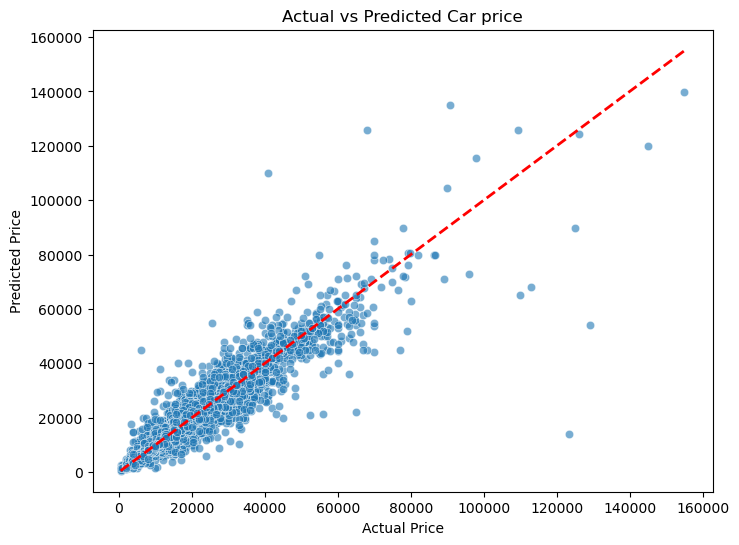

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=pred_original_scale, alpha=0.6)
lims = [min(y_val.min(), pred_original_scale.min()), max(y_val.max(), pred_original_scale.max())]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Car price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

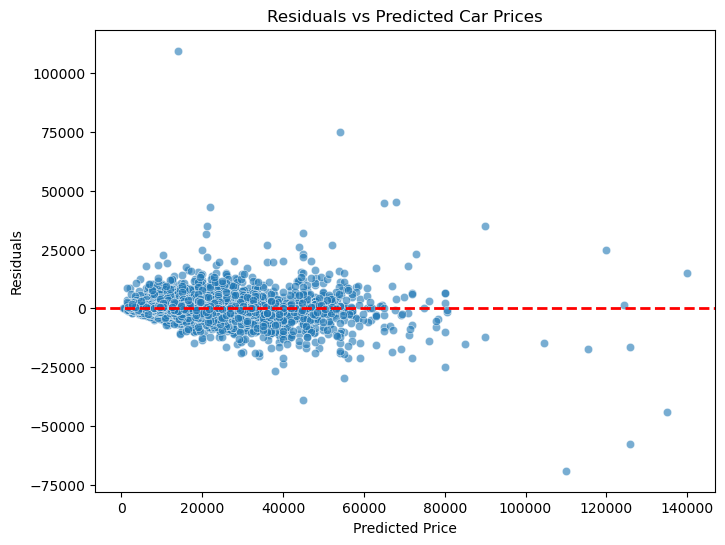

In [42]:
residuals = y_val - pred_original_scale

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_original_scale, y=residuals, alpha=0.6)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs Predicted Car Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

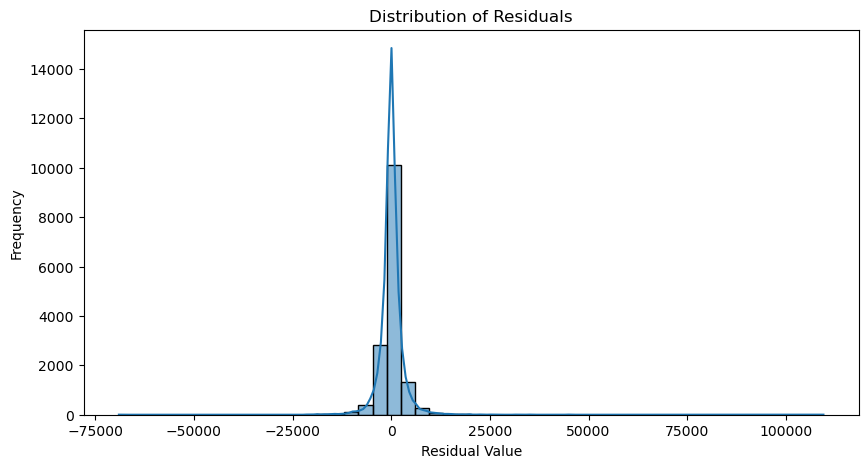

In [43]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [44]:
#Export the best model for use in test.csv dataset
#joblib.dump(best_model_2, 'best_model')

# Implementing Decision Tree Regressor

Based on the baseline models tested, the decision tree regressor was by far the best model based on a hold-out score, however, we did not assess for overfitting, which it most likely did.

In general, every model hyperparameter tuning will follow the steps:

- Doing a RandomizedSearchCV trying to cover the most ground possible given our computing resources;

- Interpreting and choosing a specific area of the parameter space, based on a selection that performed quite well and also did not overfit too much (since DTs are very prone to);

- Doing a GridSearchCV around that area;

- Deploying the model.

In [23]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
dt_pipe = Pipeline([
    ("prep", pipe_preprocessor),
    ("dt", DecisionTreeRegressor(random_state=42))
])

In [25]:
param_dist = {
    "dt__criterion": ["squared_error", "absolute_error"],
    "dt__max_depth": [5, 8, 15, 30, None],
    "dt__min_samples_split": [5, 10, 20, 30, 40],
    "dt__min_samples_leaf": [5, 10, 20, 30],
    "dt__max_features": [None, "sqrt", "log2"],
    "dt__ccp_alpha": [0.0001, 0.001, 0.01]
    }

In [43]:
%%time

search_dt = RandomizedSearchCV(
    estimator=dt_pipe,
    param_distributions=param_dist,
    n_iter=40,                         
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

search_dt.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: total: 12.6 s
Wall time: 30min 23s


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'dt__ccp_alpha': [0.0001, 0.001, ...], 'dt__criterion': ['squared_error', 'absolute_error'], 'dt__max_depth': [5, 8, ...], 'dt__max_features': [None, 'sqrt', ...], ...}"
,n_iter,40
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [44]:
cv_results = pd.DataFrame(search_dt.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending = False)
cv_results.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__min_samples_split,param_dt__min_samples_leaf,param_dt__max_features,param_dt__max_depth,param_dt__criterion,param_dt__ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,2.414979,0.525363,0.168950,0.042106,20,10,None,None,squared_error,0.0001,"{'dt__min_samples_split': 20, 'dt__min_samples...",-1681.720427,-1680.856445,-1703.978488,-1679.435171,-1677.794176,-1684.756941,9.702613,1,-1374.083984,-1362.417366,-1368.910874,-1377.702871,-1375.920165,-1371.807052,5.539257
20,1.782053,0.498370,0.140303,0.047915,10,5,None,15,squared_error,0.0010,"{'dt__min_samples_split': 10, 'dt__min_samples...",-1704.313944,-1736.278221,-1762.436271,-1718.379519,-1702.224648,-1724.726521,22.444416,2,-1414.291968,-1418.570710,-1430.010301,-1409.346034,-1402.597855,-1414.963373,9.212320
16,736.172451,82.577760,0.125870,0.015737,40,20,None,None,absolute_error,0.0001,"{'dt__min_samples_split': 40, 'dt__min_samples...",-1800.925535,-1776.167358,-1776.783580,-1769.803113,-1742.901770,-1773.316271,18.546194,3,-1558.372437,-1542.740449,-1550.451808,-1564.825548,-1560.207851,-1555.319619,7.816755
24,710.404581,55.074566,0.102155,0.015944,5,30,None,30,absolute_error,0.0001,"{'dt__min_samples_split': 5, 'dt__min_samples_...",-1847.679105,-1849.609576,-1854.317966,-1825.905028,-1822.792681,-1840.060871,13.046519,4,-1678.749070,-1679.367337,-1687.439764,-1693.509321,-1681.655062,-1684.144111,5.597998
36,562.133224,23.973827,0.113188,0.019525,30,20,None,15,absolute_error,0.0100,"{'dt__min_samples_split': 30, 'dt__min_samples...",-1852.491971,-1843.966305,-1849.689075,-1853.927274,-1819.679907,-1843.950906,12.605443,5,-1656.191336,-1651.130820,-1668.710438,-1683.313348,-1670.014939,-1665.872176,11.317588
21,167.878376,39.152509,0.159397,0.052821,10,5,sqrt,None,absolute_error,0.0001,"{'dt__min_samples_split': 10, 'dt__min_samples...",-2064.481343,-1999.151859,-2106.187364,-1965.823121,-1989.560616,-2025.040861,52.107841,6,-1759.593652,-1690.550446,-1768.528728,-1690.794386,-1658.528752,-1713.599193,42.934372
2,1.304289,0.069507,0.175073,0.055018,40,10,sqrt,None,squared_error,0.0010,"{'dt__min_samples_split': 40, 'dt__min_samples...",-2238.684185,-2283.631107,-2310.603193,-2219.295458,-2274.516182,-2265.346025,32.551976,7,-2095.582117,-2158.240176,-2157.143334,-2097.692234,-2173.100447,-2136.351662,32.919845
30,147.423120,29.474118,0.149808,0.055523,30,5,log2,30,absolute_error,0.0100,"{'dt__min_samples_split': 30, 'dt__min_samples...",-2441.857223,-2404.347318,-2261.946298,-2268.872022,-2334.649763,-2342.334525,71.649726,8,-2269.794514,-2199.019168,-2003.332884,-2089.595930,-2148.220092,-2141.992518,91.209724
35,617.526843,18.466473,0.102566,0.021145,10,5,None,8,absolute_error,0.0100,"{'dt__min_samples_split': 10, 'dt__min_samples...",-2390.286509,-2401.273939,-2421.800000,-2375.532282,-2379.658484,-2393.710243,16.648460,9,-2328.382836,-2331.083435,-2337.987660,-2340.712236,-2326.644598,-2332.962153,5.472307
28,674.773715,25.487763,0.110371,0.015873,30,20,None,8,absolute_error,0.0100,"{'dt__min_samples_split': 30, 'dt__min_samples...",-2406.662488,-2409.737776,-2430.920237,-2388.565190,-2388.217026,-2404.820543,15.803033,10,-2344.306311,-2351.334661,-2355.614087,-2362.496718,-2345.977558,-2351.945867,6.620172


In [45]:
#cv_results.head(20).to_excel("DT_RandomSearch_top_20_results_1.xlsx", index = False)

In [29]:
cv_results = pd.read_excel("../project_data/model_results/DT_RandomSearch_top_20_results_1.xlsx")

In [30]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__min_samples_split,param_dt__min_samples_leaf,param_dt__max_features,param_dt__max_depth,param_dt__criterion,param_dt__ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.414979,0.525363,0.168950,0.042106,20,10,NaN,NaN,squared_error,0.0001,"{'dt__min_samples_split': 20, 'dt__min_samples...",-1681.720427,-1680.856445,-1703.978488,-1679.435171,-1677.794176,-1684.756941,9.702613,1,-1374.083984,-1362.417366,-1368.910874,-1377.702871,-1375.920165,-1371.807052,5.539257
1,1.782053,0.498370,0.140303,0.047915,10,5,NaN,15.0,squared_error,0.0010,"{'dt__min_samples_split': 10, 'dt__min_samples...",-1704.313944,-1736.278221,-1762.436271,-1718.379519,-1702.224648,-1724.726521,22.444416,2,-1414.291968,-1418.570710,-1430.010301,-1409.346034,-1402.597855,-1414.963373,9.212320
2,736.172451,82.577760,0.125870,0.015737,40,20,NaN,NaN,absolute_error,0.0001,"{'dt__min_samples_split': 40, 'dt__min_samples...",-1800.925535,-1776.167358,-1776.783580,-1769.803113,-1742.901770,-1773.316271,18.546194,3,-1558.372437,-1542.740449,-1550.451808,-1564.825548,-1560.207851,-1555.319619,7.816755
3,710.404581,55.074566,0.102155,0.015944,5,30,NaN,30.0,absolute_error,0.0001,"{'dt__min_samples_split': 5, 'dt__min_samples_...",-1847.679105,-1849.609576,-1854.317966,-1825.905028,-1822.792681,-1840.060871,13.046519,4,-1678.749070,-1679.367337,-1687.439764,-1693.509321,-1681.655062,-1684.144111,5.597998
4,562.133224,23.973827,0.113188,0.019525,30,20,NaN,15.0,absolute_error,0.0100,"{'dt__min_samples_split': 30, 'dt__min_samples...",-1852.491971,-1843.966305,-1849.689075,-1853.927274,-1819.679907,-1843.950906,12.605443,5,-1656.191336,-1651.130820,-1668.710438,-1683.313348,-1670.014939,-1665.872176,11.317588
5,167.878376,39.152509,0.159397,0.052821,10,5,sqrt,NaN,absolute_error,0.0001,"{'dt__min_samples_split': 10, 'dt__min_samples...",-2064.481343,-1999.151859,-2106.187364,-1965.823121,-1989.560616,-2025.040861,52.107841,6,-1759.593652,-1690.550446,-1768.528728,-1690.794386,-1658.528752,-1713.599193,42.934372
6,1.304289,0.069507,0.175073,0.055018,40,10,sqrt,NaN,squared_error,0.0010,"{'dt__min_samples_split': 40, 'dt__min_samples...",-2238.684185,-2283.631107,-2310.603193,-2219.295458,-2274.516182,-2265.346025,32.551976,7,-2095.582117,-2158.240176,-2157.143334,-2097.692234,-2173.100447,-2136.351662,32.919845
7,147.423120,29.474118,0.149808,0.055523,30,5,log2,30.0,absolute_error,0.0100,"{'dt__min_samples_split': 30, 'dt__min_samples...",-2441.857223,-2404.347318,-2261.946298,-2268.872022,-2334.649763,-2342.334525,71.649726,8,-2269.794514,-2199.019168,-2003.332884,-2089.595930,-2148.220092,-2141.992518,91.209724
8,617.526843,18.466473,0.102566,0.021145,10,5,NaN,8.0,absolute_error,0.0100,"{'dt__min_samples_split': 10, 'dt__min_samples...",-2390.286509,-2401.273939,-2421.800000,-2375.532282,-2379.658484,-2393.710243,16.648460,9,-2328.382836,-2331.083435,-2337.987660,-2340.712236,-2326.644598,-2332.962153,5.472307
9,674.773715,25.487763,0.110371,0.015873,30,20,NaN,8.0,absolute_error,0.0100,"{'dt__min_samples_split': 30, 'dt__min_samples...",-2406.662488,-2409.737776,-2430.920237,-2388.565190,-2388.217026,-2404.820543,15.803033,10,-2344.306311,-2351.334661,-2355.614087,-2362.496718,-2345.977558,-2351.945867,6.620172


In [33]:
cv_results["overfit"] = (cv_results["mean_test_score"] - cv_results["mean_train_score"]) *-1
cv_results["overfit"]

0     312.949889
1     309.763147
2     217.996652
3     155.916760
4     178.078730
5     311.441668
6     128.994363
7     200.342007
8      60.748090
9      52.874676
10     63.757579
11     56.074010
12     56.074010
13     56.074010
14    122.421251
15    116.612907
16    121.351026
17     80.731004
18    103.095377
19     91.065988
Name: overfit, dtype: float64

- By looking at the results, even tought the best performance tree in validation as a mean MAE of ~ 1700 it also has a lot of overfit since it's the one with the most overfit on the top 20.
- The 4th and 5th trees are the most interesting by now, they have similar performance on val (~1840) and the amount of overfit is less than half compared to the top 2 on validation performance.

<hr>

### Parameters Decision Tree 4 vs Decision Tree 5

Tree | min_samples_split | min_samples_leaf | max_features| max_depth | criterion | ccp_alpha 
---| --- | --- | --- | --- |--- |---
Tree 4  | 5 | 30 | Nan | 30 | MAE | 0.0001 
Tree 5 | 30 | 20 | Nan | 15 | MAE | 0.01

<hr>

When looking at the parameters of each one, the 5th model seems to have the most robust setting to avoid overfitting since:
- The number of samples to allow spliting is much bigger
- It does only allow a depth of 15, wich is half the size of the model 4
- The ccp_alpha is much higher, which better prevents uncessary complexity when the gains are too low

In [48]:
param_grid = {
    "dt__max_depth": [12, 15, 18],
    "dt__min_samples_leaf": [15, 20, 25],
    "dt__min_samples_split": [20, 30, 40],
    "dt__ccp_alpha": [0.005, 0.01, 0.02],
    "dt__criterion": ["absolute_error"],
    "dt__max_features": [None]
}

In [ ]:
%%time

grid_search_dt = GridSearchCV(
    estimator=dt_pipe,
    param_distributions=param_grid,                         
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search_dt.fit(X, y)